주어진 데이터를 탐색해보기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

pd.set_option('display.max_row', 5)

## 1. Data Load    
컬럼은 4개로 userID, movieID, rating(평점), 데이터 시점 정보이다. 

In [10]:
df = pd.read_csv('movielens/ratings.csv')
print('columns names')
print(f'\t {df.columns}' )
print('columns shape')
print(f'\t {df.shape}' )
df.head()

columns names
	 Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
columns shape
	 (100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


---
## 2. preprocess     
### 1) Feature

In [11]:
df['date'] = pd.to_datetime(df['timestamp'].astype(int), unit='s')
df['year'] = df['date'].apply(lambda x: x.year)
df.head()

,userId,movieId,rating,timestamp,date,year
0,1,31,2.5,1260759144,2009-12-14 02:52:24,2009
1,1,1029,3.0,1260759179,2009-12-14 02:52:59,2009
2,1,1061,3.0,1260759182,2009-12-14 02:53:02,2009
3,1,1129,2.0,1260759185,2009-12-14 02:53:05,2009
4,1,1172,4.0,1260759205,2009-12-14 02:53:25,2009


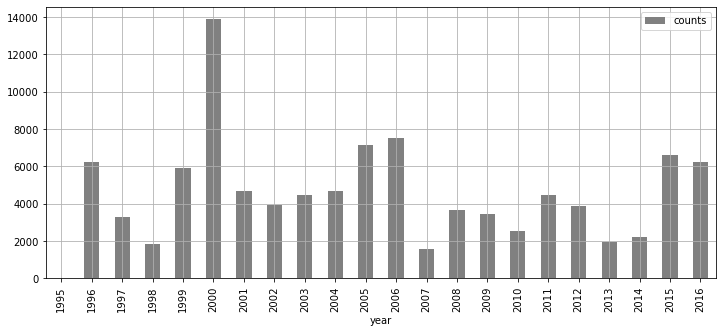

In [38]:
yearCntSR = df.groupby('year').size()
yearCntDF = pd.DataFrame(data = yearCntSR, columns = ['counts'])

yearCntDF.plot(kind='bar'
               , figsize=(12, 5)
               , label='counts'
               , legend=True
               , color = 'gray')
plt.grid()

### 2) Split train/test

In [17]:
train = df.sample(frac=0.9, random_state=1)
train['type'] = 'train'
train.head()

,userId,movieId,rating,timestamp,date,year,type
99778,667,446,4.0,847271818,1996-11-06 09:16:58,1996,train
16170,104,71135,3.5,1446674062,2015-11-04 21:54:22,2015,train
3521,19,1394,5.0,855192061,1997-02-06 01:21:01,1997,train
55070,395,671,5.0,953007109,2000-03-14 04:11:49,2000,train
25477,187,953,3.0,1230361942,2008-12-27 07:12:22,2008,train


In [18]:
test = df.drop(train.index)
test['type'] = 'test'
test.head()

,userId,movieId,rating,timestamp,date,year,type
9,1,1343,2.0,1260759131,2009-12-14 02:52:11,2009,test
15,1,2193,2.0,1260759198,2009-12-14 02:53:18,2009,test
18,1,2968,1.0,1260759200,2009-12-14 02:53:20,2009,test
27,2,110,4.0,835355532,1996-06-21 11:12:12,1996,test
47,2,273,4.0,835355779,1996-06-21 11:16:19,1996,test


## 3. Anaylsis

### 1) 평균값을 예측값이라 보고 정확도를 측정해보면

In [22]:
# train의 평균이 테스트의 예측값으로 입력! 
avgPred = test[['userId', 'movieId', 'rating']].copy()
avgPred['pred'] = train['rating'].mean()
avgPred.head()

,userId,movieId,rating,pred
9,1,1343,2.0,3.542115
15,1,2193,2.0,3.542115
18,1,2968,1.0,3.542115
27,2,110,4.0,3.542115
47,2,273,4.0,3.542115


In [23]:
avgPredErrors = avgPred['pred'] - avgPred['rating']
mae  = avgPredErrors.abs().mean()
rmse = math.sqrt(avgPredErrors.pow(2).mean())
print(mae)
print(rmse)

0.8586874505577452
1.0629409004509174


### 2) user 별 평점 평균

In [34]:
userAvgRatings = train[['userId', 'rating']].groupby('userId').agg('mean')
userAvgRatings.columns = ['pred']
userAvgRatings.head()

,pred
userId,
1,2.705882
2,3.485294
3,3.579545
4,4.351351
5,3.893617


In [29]:
userAvgPred = test[['userId', 'movieId', 'rating']]
userAvgPred = pd.merge(userAvgPred, userAvgRatings
                       , how='left'
                       , left_on=['userId']
                       , right_on=['userId']
                       , right_index = False)
print(userAvgPred['pred'].isnull().sum()) # 예측값이 안나온 케이스
userAvgPred.head()

0


,userId,movieId,rating,pred
0,1,1343,2.0,2.705882
1,1,2193,2.0,2.705882
2,1,2968,1.0,2.705882
3,2,110,4.0,3.485294
4,2,273,4.0,3.485294


In [30]:
userAvgPredErrors = userAvgPred['pred'] - userAvgPred['rating']
mae2 = userAvgPredErrors.abs().mean()
rmse2 = math.sqrt(userAvgPredErrors.pow(2).mean())
print(mae2)
print(rmse2)

0.7581636860631095
0.9652871605248957


### 3) 영화 별 평균을 예측값으로 사용하기 

In [32]:
itemAvgRatings = train[['movieId', 'rating']].groupby('movieId').agg('mean')
itemAvgRatings.columns = ['pred']

itemAvgPred = test[['userId', 'movieId', 'rating']]
itemAvgPred = pd.merge(itemAvgPred, itemAvgRatings, how='left', left_on=['movieId'], right_on=['movieId'], right_index = False)
itemAvgPred.head()

,userId,movieId,rating,pred
0,1,1343,2.0,3.720588
1,1,2193,2.0,3.166667
2,1,2968,1.0,3.587500
3,2,110,4.0,3.923858
4,2,273,4.0,3.125000


In [33]:
itemAvgPredErrors = itemAvgPred['pred'] - itemAvgPred['rating']
mae3 = itemAvgPredErrors.abs().mean()
rmse3 = math.sqrt(itemAvgPredErrors.pow(2).mean())
print(mae3)
print(rmse3)

0.7614649796369113
0.9747682577638201
